In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import lite
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.metrics import Precision, Recall
from keras.models import load_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [2]:
batch_size = 32
image_height = 512
image_width = 512
epoch = 48

In [3]:
train_path = 'Kidney/train'
test_path = 'Kidney/test'
val_path = 'Kidney/val'

In [4]:
def plotting_images(item_dir, num_imgs=5):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.axis('off')
        plt.imshow(img)

    plt.tight_layout()

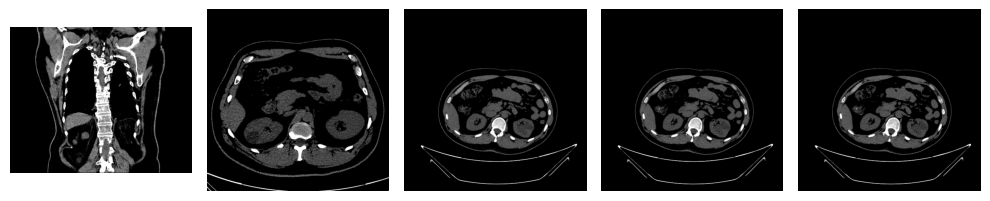

In [5]:
plotting_images("Kidney/train/Cyst")

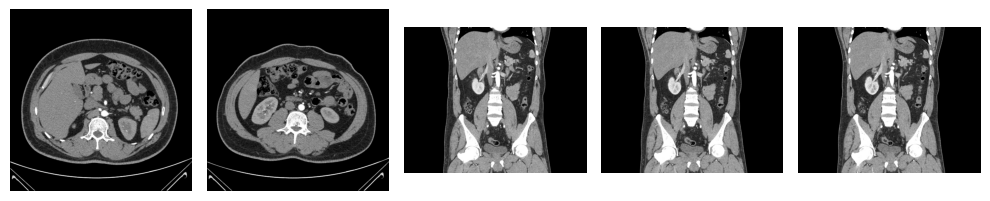

In [6]:
plotting_images("Kidney/train/Normal")

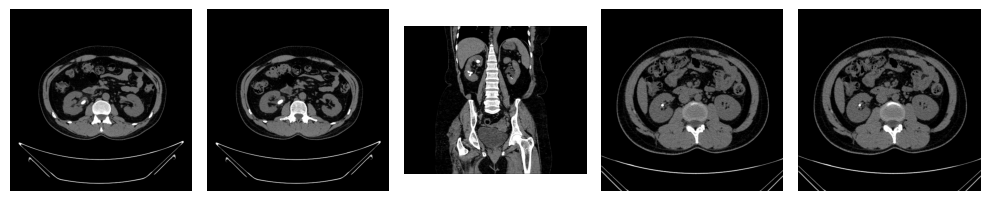

In [7]:
plotting_images("Kidney/train/Stone")

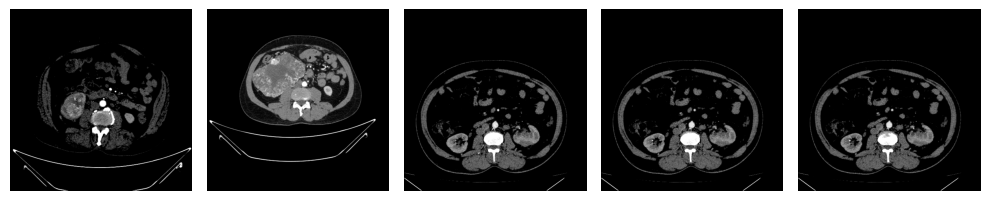

In [8]:
plotting_images("Kidney/train/Tumor")

In [9]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

In [10]:
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(image_height, image_width),
                                                  color_mode='grayscale', 
                                                  class_mode='categorical', 
                                                  batch_size= batch_size,
                                                  )

test_dataset = test_datagen.flow_from_directory(test_path,
                                                target_size=(image_height, image_width),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                batch_size= batch_size,
                                                shuffle=False
                                                )

valid_dataset = valid_datagen.flow_from_directory(val_path,
                                                  target_size=(image_height, image_width),
                                                  class_mode='categorical',
                                                  batch_size= batch_size,
                                                  color_mode='grayscale',
                                                  )

Found 9866 images belonging to 4 classes.
Found 1232 images belonging to 4 classes.
Found 1244 images belonging to 4 classes.


In [11]:
checkpoint = ModelCheckpoint("Training_data_Kidney-1.h5", mode='auto', save_freq=1)

In [12]:
model = Sequential([
  
    Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=train_dataset.image_shape), 
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax'),
 
])

In [13]:
METRICS = [
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)

In [14]:
model_fit = model.fit(train_dataset,
                      validation_data=valid_dataset,
                      steps_per_epoch=10,
                      epochs = epoch,
                      callbacks=[checkpoint])

Epoch 1/48
10/10 [==============================] - 155s 16s/step - loss: 1.4897 - accuracy: 0.3781 - precision: 0.5312 - recall: 0.0531 - val_loss: 1.3138 - val_accuracy: 0.2974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/48
10/10 [==============================] - 143s 14s/step - loss: 1.2922 - accuracy: 0.4406 - precision: 0.5000 - recall: 0.0531 - val_loss: 1.2561 - val_accuracy: 0.4084 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/48
10/10 [==============================] - 127s 13s/step - loss: 1.2273 - accuracy: 0.4219 - precision: 0.7143 - recall: 0.1719 - val_loss: 1.2287 - val_accuracy: 0.4084 - val_precision: 0.9861 - val_recall: 0.0571
Epoch 4/48
10/10 [==============================] - 134s 14s/step - loss: 1.2265 - accuracy: 0.4375 - precision: 0.6095 - recall: 0.2000 - val_loss: 1.3108 - val_accuracy: 0.3031 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/48
10/10 [==============================] - 127s 13s/step - loss: 1.2044

In [15]:
model.save('Training_data_Kidney-1.h5')

In [16]:
tf_model = load_model("Training_data_Kidney-1.h5")
converter = lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("Training_data_Kidney_lite.tflite", 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\VISHAL~1\AppData\Local\Temp\tmpj_9e1_av\assets


INFO:tensorflow:Assets written to: C:\Users\VISHAL~1\AppData\Local\Temp\tmpj_9e1_av\assets


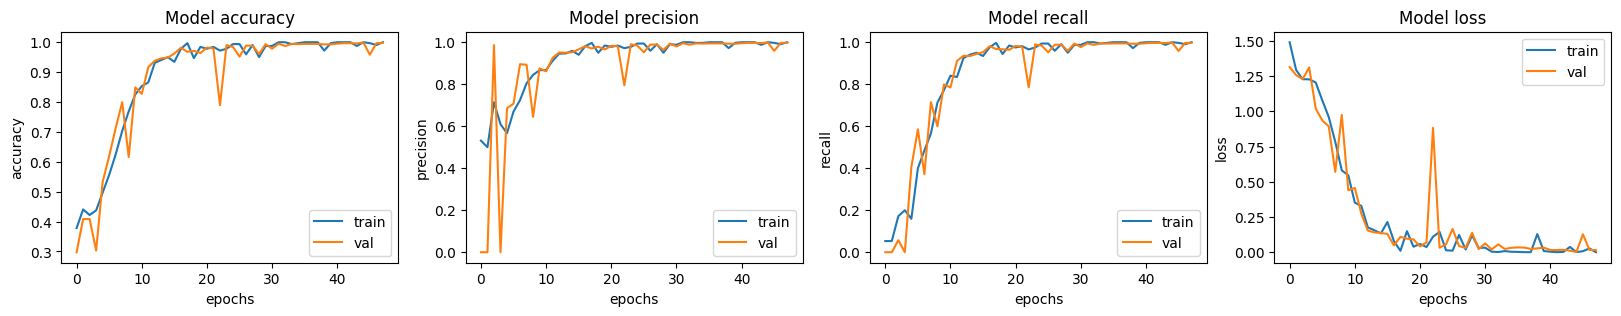

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy','precision','recall', 'loss']):
    ax[i].plot(model_fit.history[met])
    ax[i].plot(model_fit.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [18]:
predictions = model.predict(test_dataset)

39/39 [==============================] - 66s 2s/step


In [19]:
diseases_labels = []

for key, value in train_dataset.class_indices.items():
   diseases_labels.append(key)

In [20]:
def evaluate(actual, predictions):
  pre = []
  for i in predictions:
    pre.append(np.argmax(i))

  accuracy = (pre == actual).sum() / actual.shape[0]
  print(f'Accuracy: {accuracy}')

  precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1_score: {f1_score}')

  fig, ax = plt.subplots(figsize=(5,5))
  conf_mat = confusion_matrix(actual, pre)
  sns.heatmap(conf_mat, annot=True, fmt='.0f', xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
  plt.show()

Accuracy: 0.997564935064935
Precision: 0.9946808510638298
Recall: 0.9979784366576819
F1_score: 0.996296942977287


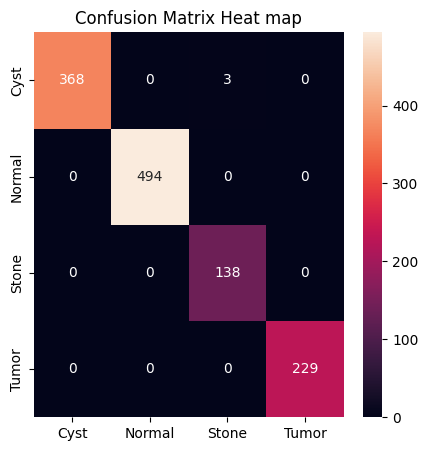

In [21]:
evaluate(test_dataset.classes,predictions)

In [22]:
model.evaluate(test_dataset)

39/39 [==============================] - 65s 2s/step - loss: 0.0136 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976


[0.013606059364974499,
 0.9975649118423462,
 0.9975649118423462,
 0.9975649118423462]